Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
RMSE on validation data: 25752.52287231868


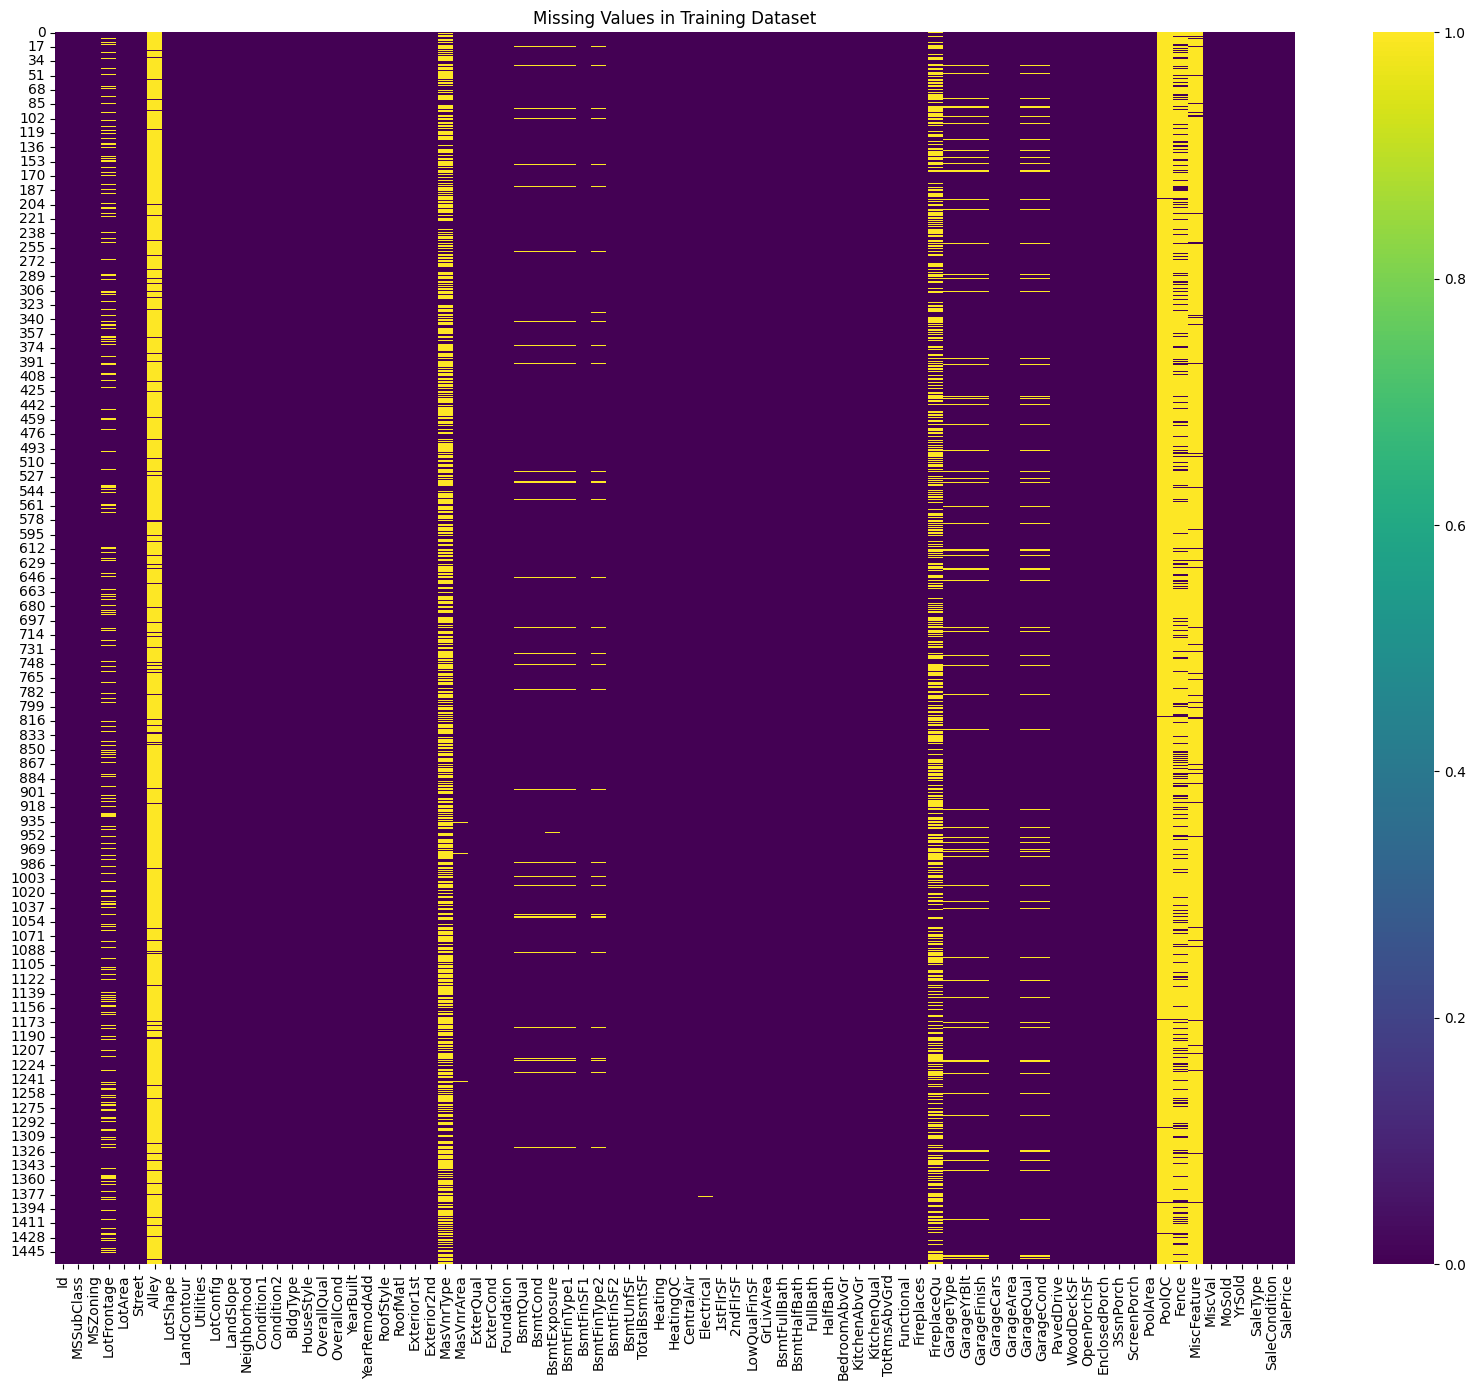

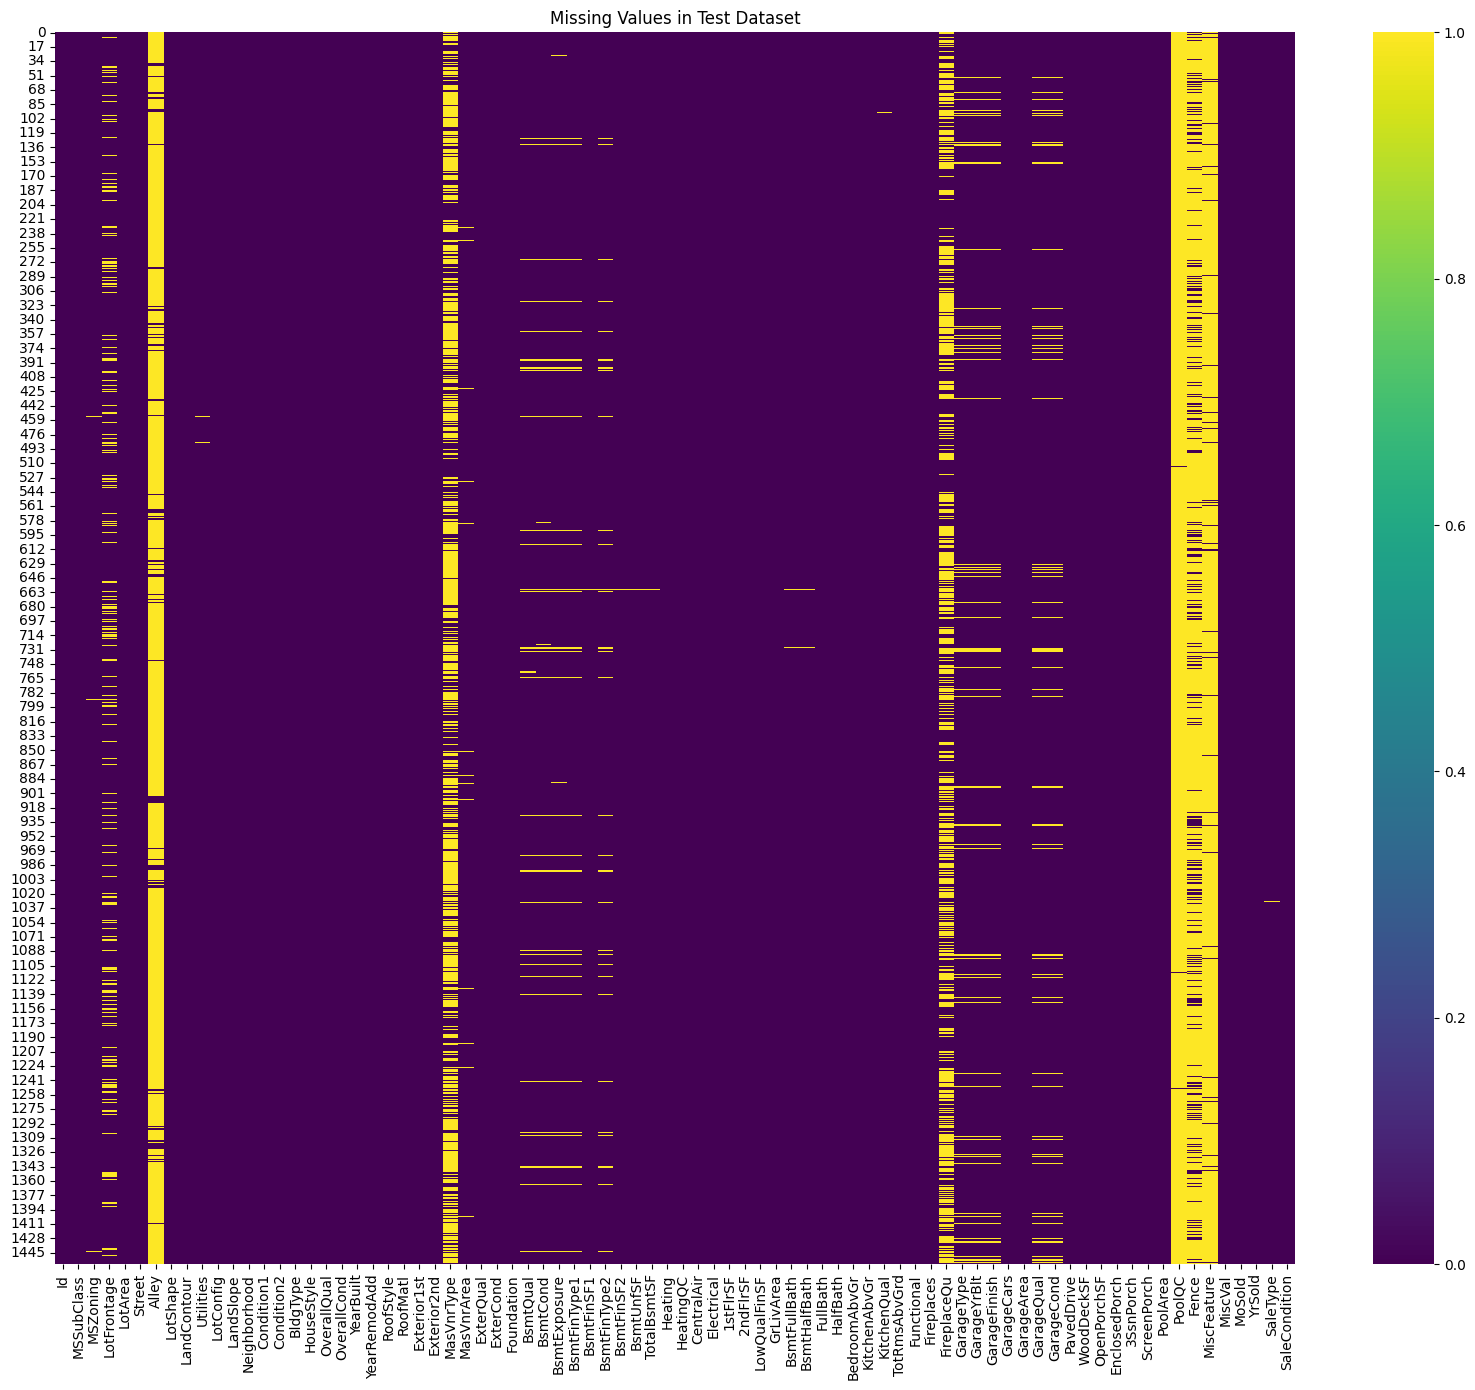

In [12]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

# Load the training and test datasets
df = pd.read_csv("/content/drive/MyDrive/train.csv")
test = pd.read_csv("/content/drive/MyDrive/test.csv")

# Increase display options for better visibility
pd.options.display.max_columns = 4000
pd.options.display.max_rows = 4000

# Visualize missing values in the training dataset using a heatmap
fig_dims = (20,16)
fig, ax = plt.subplots(figsize=fig_dims)
sns.heatmap(df.isnull(), cmap='viridis')
plt.title('Missing Values in Training Dataset')

# Drop columns with a high proportion of missing values
df.drop(['Alley','PoolQC','Fence','MiscFeature'], axis=1, inplace=True)

# Impute missing values in numerical columns
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].mean())
df['MasVnrArea'] = df['MasVnrArea'].fillna(df['MasVnrArea'].mean())

# Impute missing values in categorical columns
df['MasVnrType'] = df['MasVnrType'].fillna(df['MasVnrType'].mode()[0])
df['BsmtQual'] = df['BsmtQual'].fillna(df['BsmtQual'].mode()[0])
# Continue this process for other columns...

# Visualize missing values in the test dataset using a heatmap
fig, ax = plt.subplots(figsize=fig_dims)
sns.heatmap(test.isnull(), cmap='viridis')
plt.title('Missing Values in Test Dataset')

# Similar data preprocessing steps for the test dataset...

# Concatenate the training and test datasets for preprocessing
Combined_df = pd.concat([df, test], axis=0)

# Perform one-hot encoding for categorical variables
for_object = Combined_df.select_dtypes(include='object')
columns = list(for_object.columns)
com_with_dummy = pd.get_dummies(Combined_df, columns=columns, drop_first=True)

# Remove duplicate columns
com_with_dummy = com_with_dummy.loc[:, ~com_with_dummy.columns.duplicated()]

# Split the combined dataset back into training and test datasets
train_df = com_with_dummy.iloc[:1460, :]
test_df = com_with_dummy.iloc[1460:, :]

# Ensure test dataset has the same columns as the training dataset
test_df = test_df[train_df.columns]

# Drop the target variable 'SalePrice' from the test dataset
test_df.drop(['SalePrice'], axis=1, inplace=True)

# Prepare training data and target variable
X = train_df.drop(['SalePrice'], axis=1)
y = train_df['SalePrice']

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Parameter grid for grid search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300]
}

# Initialize and train the XGBoost Regressor using GridSearchCV
Classifier = XGBRegressor()
grid_search = GridSearchCV(Classifier, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best parameters from grid search
best_params = grid_search.best_params_

# Initialize XGBoost with the best parameters
best_Classifier = XGBRegressor(**best_params)
best_Classifier.fit(X_train, y_train)

# Make predictions on the validation dataset
y_pred_valid = best_Classifier.predict(X_valid)

# Calculate RMSE on validation data
rmse_valid = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
print("RMSE on validation data:", rmse_valid)

# Make predictions on the test dataset
y_pred_test = best_Classifier.predict(test_df)

# Load the sample submission file
sub_df = pd.read_csv("/content/drive/MyDrive/sample_submission.csv")

# Create a DataFrame for submission
submission = pd.DataFrame({
    'Id': sub_df['Id'],
    'SalePrice': y_pred_test
})

# Save the submission DataFrame to a CSV file
submission.to_csv('/content/drive/MyDrive/our_file.csv', index=False)
